# Introduction

**Team:** Ivana Josipovic, Adrian Miramontes, Ariadna Davila  
**Date:** 26 September 2025

This notebook presents the Computational Carpentry project for Group Q. The project is organized into three blocks. For each block:
1. The original prompt from Moodle is shown in bold.
2. Explanations and reflections are provided in markdown cells.
3. The corresponding Python code is included in code cells.
4. For functions where we originally made mistakes, we included the failed attempts between two horizontal lines and explained why they didn’t work.

This structure follows the principles of literate programming, where code and commentary are combined to explain both the process and the reasoning behind each step. We also included failed or exploratory attempts and explained why they didn’t work.

# Part A - Data structures and functions

This section consists in loading a dataset of elements from the periodic table, then building a dictionary for fast lookups, and finally writung functions to calculate molecular masses.

### 1. Load the “periodic_table.csv” data file using pandas

 First, we import the libraries needed for computation and plotting andload data from disk to begin analysis. We use the read_cvs function of pandas.

In [26]:
import pandas as pd

file = pd.read_csv("periodic_table.csv")

### 2. Create a python dictionary where the keys are elements symbol and the values are atomic masses

By assuming our file (the periodic table) has two columns, we can assign each element symbol to its atomic mass, which is analogous to creating a dictionary having a key that corresponds to a value where: 
- Keys = element symbols (e.g., `'H'`, `'O'`, `'Na'`)
- Values = their atomic masses.

We tried to do it with "for element, atomic_number in periodic_table:" first, but that did not work. This is due to the fact that we actually have to iterate over 2 columns and not 1 column and 1 row. Therefore, we have to use zip.


In [27]:
element = file['Symbol']
atomic_mass = file['AtomicMass']
periodic_table_dictionary = dict(zip((element), atomic_mass))

### 3. Write a function that takes chemical formulas like “H2O” and “C6H12O6” and return their molecular mass

In order to calculate the molecular weight, we used an iteration through the chemical formula as a string, which would allow us to detect an element and the number of atoms of that element. This function consists in the following steps: 

1. Initialize empty strings for `element` and `count`, and set `total_mass = 0`. 

2. Loop through the formula one character at a time.  

3. If the character is uppercase, that means a new element begins: 

   - Add the previous element’s contribution (`atomic mass × count`) to `total_mass`.  
   - Reset `count` and start the new element.  

4. If the character is **lowercase**, append it to the current element symbol (e.g., `"Cl"`). 

5. If the character is a **digit**, append it to `count` to record how many atoms of that element there are.  

6. Continue until all characters have been processed.  

7. After the loop, add the last element’s contribution to `total_mass` and return the result.  

This is our first version, which works for simple formulas like `H2O` and `C6H12O6`. 

In [28]:
def calculate_molecular_mass(formula: str) -> float:
    #create an empty string to store the element and count
    element = ''
    count = ''
    total_mass = 0

    i = 0
    while i < len(formula):
        character = formula[i]

        if character.isupper():
            if element:
                atomic_mass = periodic_table_dictionary[element]
                multiplier = int(count) if count else 1
                total_mass += atomic_mass * multiplier
                count = ''
            #start a new element
            element = character

        elif character.islower():
            element += character

        elif character.isdigit():
            count += character

        i += 1

    #last element in the formula
    if element:
        atomic_mass = periodic_table_dictionary[element]
        multiplier = int(count) if count else 1
        total_mass += atomic_mass * multiplier

    return total_mass

print(f"Molar mass of H2O: {calculate_molecular_mass('H2O'):.2f}")
print(f"Molar mass of C6H12O6: {calculate_molecular_mass('C6H12O6'):.2f}") 

Molar mass of H2O: 18.02
Molar mass of C6H12O6: 180.16


### 4. Extend the molecular mass calculator to handle parentheses in formulas

Some chemical formulas include parentheses to indicate groups of atoms, such as `(OH)2`. Our earlier function cannot handle this.

Here, we have to implement recursive programming in order to get the correct molecular mass. This implies that we have to call the function within itself. In this case, when we see parentheses, the function calls itself to compute the mass of the sub-formula inside, then multiplies by the number outside.  

This way, the function correctly interprets more complex formulas like `Ca(OH)2` or `Al2(SO4)3`.

In [29]:
def extended_calculate_molecular_mass(formula: str) -> float:
    #create an empty string to store the element and count
    element = ''
    count = ''
    total_mass = 0

    i = 0
    while i < len(formula):
        character = formula[i]

        if character.isupper():
            if element:
                atomic_mass = periodic_table_dictionary[element]
                multiplier = int(count) if count else 1
                total_mass += atomic_mass * multiplier
                count = ''
            #start a new element
            element = character

        elif character.islower():
            element += character

        elif character.isdigit():
            count += character
        elif character == '(':
            j = i + 1
            while formula[j] != ')':
                j += 1
            subformula = formula[i+1:j]
            sub_mass = calculate_molecular_mass(subformula)
            i = j + 1
            sub_count = ''
            while i < len(formula) and formula[i].isdigit():
                sub_count += formula[i]
                i += 1
            multiplier = int(sub_count) if sub_count else 1
            total_mass += sub_mass * multiplier
            continue

        i += 1

    #last element in the formula
    if element:
        atomic_mass = periodic_table_dictionary[element]
        multiplier = int(count) if count else 1
        total_mass += atomic_mass * multiplier

    return total_mass

print(f"Molar mass of Ca(OH)2: {calculate_molecular_mass('Ca(OH)2'):.2f} g/mol")
print(f"Molar mass of Al2(SO4)3: {calculate_molecular_mass('Al2(SO4)3'):.2f} g/mol")

Molar mass of Ca(OH)2: 58.09 g/mol
Molar mass of Al2(SO4)3: 773.99 g/mol


### 5. Extend the molecular mass calculator so it can handle coordinated (hydration) water

Some compounds, especially salts, crystallize with a fixed number of water molecules attached. For example, copper(II) sulfate pentahydrate is written as `CuSO4·5H2O`. The dot (`·`) indicates that 5 water molecules are coordinated with each unit of CuSO₄. Once again, our previous function cannot handle the case

To extend our function, we need to split the input formula at the dot, extract the number of water molecules, and add their mass to the main compound's mass. Our function `coordinated_water_molecular_mass(formula)` handles this case and can be summarised as follows:

1. Split the formula into two parts:  
   - the main compound before the dot (e.g., `CuSO4`)  
   - the hydration part after the dot (e.g., `5H2O`)  

2. Extract the number of water molecules (e.g., `5`).  
   - If no number is given, assume `1`.  

3. Calculate the mass of the main compound using the extended function.  

4. Calculate the mass of water (`H2O`) once, and multiply it by the hydration count.  

5. Add them together to get the total molar mass of the hydrated compound.  

For coordinated water molecules, we can now add the mass of the respective water molecules that are present in the coordination complex. 

In [30]:
def coordinated_water_molecular_mass(formula):
    i = 0
    if formula[i] != '.':
        i += 1
        main_formula = formula[:i]
        hydration_part = formula[i+1:]
        hydration_count = ''
        j = 0
    while j < len(hydration_part) and hydration_part[j].isdigit():
        hydration_count += hydration_part[j]
        j += 1
    hydration_count = int(hydration_count) if hydration_count else 1
    main_mass = extended_calculate_molecular_mass(main_formula)
    water_mass = periodic_table_dictionary['H'] * 2 + periodic_table_dictionary['O']
    total_mass = main_mass + (water_mass * hydration_count)
    return total_mass

print(f"Molar mass of CuSO4·5H2O: {coordinated_water_molecular_mass('CuSO4.5H2O'):.2f} g/mol")

Molar mass of CuSO4·5H2O: 30.03 g/mol


# Part B - Stoichiometry and reaction balancing

### 1. Reaction Balancer Function

**a. Write a function balance_reaction(reactants, products) that:**

- **Takes as input:**
    - **reactants: list of chemical formulas for reactants (e.g., [“H2”, “O2”])**
    - **products: list of chemical formulas for products (e.g., [“H2O”])**

- **Returns: a list of stoichiometric coefficients that balances the reaction.**

- **You don’t need to consider parenthesis or “.” in the formula for this problem** 

- **Hint: You can represent the reaction as a system of linear equations based on the number of atoms of each element. Look up the term Singular Value Decomposition, you can use this link.**

- **Test it for 3 reactions of your choice.**

Our approach in constructing this function consists in the following steps:

1. Parse each chemical formula into a mapping `{element: count}` using a regular expression (e.g., `"H2O" → {"H": 2, "O": 1}`).  
2. Build a matrix \(A\) with one row per element and one column per species (reactants first, products after).  
   - For reactants, we put +counts; for products, −counts.  
   - A balanced reaction satisfies \(A \cdot x = 0\), where \(x\) is the vector of stoichiometric coefficients.
3. Find a non‑trivial vector in the null space of \(A\) via singular Value Decomposition (SVD). The last right-singular vector (row of \(V^T\)) corresponds to the smallest singular value and approximates the null space direction.

4. Convert real coefficients to minimal integers by scaling:
   - Normalize, convert to fractions, take the least common multiple (LCM) of denominators, and reduce by the greatest common divisor (GCD).
5. Safety checks:
   - If an element appears on only one side → impossible.
   - If any resulting integer coefficient is non‑positive → reject as infeasible.
6. Print the balanced equation.

In [3]:
from __future__ import annotations
import re
import numpy as np
from fractions import Fraction
from math import gcd
from functools import reduce

We need a function that reads a chemical formula (e.g. `H2O`) and returns the count of each atom. This helps us build the matrix of equations later. 

In [4]:
# Regular expression to extract elements and counts
element_re = re.compile(r"([A-Z][a-z]?)(\d*)")

def parse_formula(formula: str) -> dict:
    counts = {}
    for (elem, num) in element_re.findall(formula):
        n = int(num) if num else 1
        counts[elem] = counts.get(elem, 0) + n
    if not counts:
        raise ValueError(f"Could not parse formula: {formula}")
    return counts

print("parse_formula('H2O') =", parse_formula("H2O"))

parse_formula('H2O') = {'H': 2, 'O': 1}



Since we will need to scale fractions to integers, we will use the function lcm(). This function finds the least common multiple of two integers. For example, lcm(3,4,12) is 12 a more complex example is where the numbers are not multiples of each other. For example, lcm(3,5, 7, and 11). 

In [7]:
def lcm(a, b):
    return a * b // gcd(a, b)

def lcm_many(ints):
    return reduce(lcm, ints, 1)

print("least common multiple of 2, 3, 4:", lcm_many([2, 3, 4]))       # → 12
print("least common multiple of 3, 5, 7, 11:", lcm_many([3, 5, 7, 11]))   # → 1155

least common multiple of 2, 3, 4: 12
least common multiple of 3, 5, 7, 11: 1155


the function `_elements_by_side` has as an input the reactants and products of a reaction and returns two sets:

`rset`: elements present in at least one reactant
`pset`: elements present in at least one product

For example if we were to do the following reaction: C3H7OH + O2 -> CO2 + H2O, there would only be three element in the reactants and three element in the products: `{H}` `{C}` and `{O}`.

In [14]:
def _elements_by_side(reactants, products):
    rset = set()
    pset = set()
    for f in reactants:
        rset.update(parse_formula(f).keys())
    for f in products:
        pset.update(parse_formula(f).keys())
    return rset, pset

rset, pset = _elements_by_side(["C3H7OH", "O2"], ["CO2", "H2O"])
print("Reactant elements:", rset)
print("Product elements :", pset)

Reactant elements: {'O', 'H', 'C'}
Product elements : {'O', 'H', 'C'}


However, if there were a product that was not in the reactants, then the reaction is not possible. By substracting rset from pset we can see if there are any elements in the products that are not in the reactants. This makes an early impossibility easy to spot. For example imagine the impossible reaction: H2+O2 -> NH3.  

In [12]:
rset, pset = _elements_by_side(["H2", "O2"], ["NH3"])
print("Reactant elements:", rset)
print("Product elements :", pset)
print("Only in products:", pset - rset)

Reactant elements: {'O', 'H'}
Product elements : {'N', 'H'}
Only in products: {'N'}


The following function tskes lists of chemical formulas (reactants and products) and returns a list of integer stoichiometric coefficients that balance the reaction. Our approach was the following

1. Extracting the sets of elements from reactants and products. If an element exists only in reactants or only in products, balancing is impossible.

2. Building the element matrix. Rows = elements, Columns = species (reactants first, then products). Reactant entries are positive, product entries are negative. A balanced reaction satisfies A · x = 0, where x is the coefficient vector.

3. Finding the null space using Singular Value Decomposition (SVD). 

4. Scaling to minimal integers. The vector v has to be normalized so the smallest nonzero entry is 1. Then the least common multiple of the denominators is found and multiplied through to ensure all coefficients are integers. 

5. Since the nullspace vector that SVD returns is not unique. If v is in the nullspace, then so is -v. The algorithm may give you one or the other. However, coefficients in chemical reactions have to be positive, thus, the sign is flipped if necessary. 

6. To ensure that the coefficients are in the lowest possible ratio, all coefficients are divided by their Greatest Common Divisor (GCD).

5. Lastly, the results are validated: If no non-zero solution exists or if any coefficient is ≤ 0 an error ir raised.

The function can be tested with the following reaction: 

`C3H8 + O2 → CO2 + H2O` -> this is entered in the function as reactans = `['C3H8', 'O2']` and products = `['CO2', 'H2O']` and the output will be the coefficients to balance the reaction: `[1, 5, 3, 4]`

In [17]:
def balance_reaction(reactants, products, tol=1e-10):
    # Early impossibility: elements only on one side
    rset, pset = _elements_by_side(reactants, products)
    only_in_reactants = sorted(rset - pset)
    only_in_products = sorted(pset - rset)
    if only_in_reactants or only_in_products:
        parts = []
        if only_in_reactants:
            parts.append(f"present only in reactants: {', '.join(only_in_reactants)}")
        if only_in_products:
            parts.append(f"present only in products: {', '.join(only_in_products)}")
        raise ValueError("Reaction not possible with the chosen species because some elements are missing on one side ("
                         + "; ".join(parts) + ").")
    
    species = reactants + products
    parsed = [parse_formula(f) for f in species]
    elements = sorted({e for m in parsed for e in m.keys()})
    
    A = np.zeros((len(elements), len(species)), dtype=float)
    for i, el in enumerate(elements):
        for j, m in enumerate(parsed):
            count = m.get(el, 0)
            if j >= len(reactants):  # product side negative
                count = -count
            A[i, j] = count
    
    # SVD nullspace
    U, S, Vt = np.linalg.svd(A)
    v = Vt[-1, :]
    v[np.abs(v) < tol] = 0.0
    if np.allclose(v, 0, atol=tol):
        raise RuntimeError("Nullspace vector is numerically zero; try different tolerance.")
    
    # Normalize to minimal integers
    nonzero = v[np.abs(v) > tol]
    v_scaled = v / np.min(np.abs(nonzero))
    fracs = [Fraction(float(x)).limit_denominator(1000) for x in v_scaled]
    denoms = [f.denominator for f in fracs]
    L = lcm_many(denoms)
    ints = np.array([int(f.numerator * (L // f.denominator)) for f in fracs], dtype=int)
    
    # Flip sign to make most entries positive if needed
    if np.sum(ints < 0) > np.sum(ints > 0):
        ints *= -1
    
    # Reduce GCD
    nonzero_ints = ints[ints != 0]
    if len(nonzero_ints) == 0:
        raise ValueError("Reaction not possible with the chosen species (no non-zero solution).")
    g = reduce(gcd, map(int, np.abs(nonzero_ints)))
    if g > 1:
        ints //= g
    
    # Feasibility: require all strictly positive coefficients for chosen species
    if np.any(ints <= 0):
        raise ValueError("Reaction not possible since products are not registered as products of the reactants.")
    
    return ints.tolist()

print(f"Coefficients of reaction: C3H8 + O2 → CO2 + H2O: {balance_reaction(["C3H8", "O2"], ["CO2", "H2O"])}")

Coefficients of reaction: C3H8 + O2 → CO2 + H2O: [1, 5, 3, 4]


Now lets try a reaction that will not work:

`H2 ​+ O2 ​→ CO2​​` -> this reaction does not exist since there is an element in the products that doesnt exist in the reactants. 

In [18]:
print(f"Coefficients of reaction: H2 ​+ O2 ​→ CO2​: {balance_reaction(["H2", "O2"], ["CO"])}")

ValueError: Reaction not possible with the chosen species because some elements are missing on one side (present only in reactants: H; present only in products: C).

Now that we have the coefficients, it is convenient for the equation to come out in a readable format. Thus the function `format_equation` is created which prints a human-readable equation. Taking chemical reaction `C3H8 + O2 → CO2 + H2O` and `CHClF2 → C2F4 + HCl` as an example. 

In [23]:
def format_equation(reactants, products):
    lhs = " + ".join([f"{c if c!=1 else ''}{r}".strip() for c, r in zip(balance_reaction(reactants, products), reactants)])
    rhs = " + ".join([f"{c if c!=1 else ''}{p}".strip() for c, p in zip(balance_reaction(reactants, products), products)])
    return f"{lhs} → {rhs}"

print(format_equation(["C3H8", "O2"], ["CO2", "H2O"]))
print(format_equation(["CHClF2"], ["C2F4", "HCl"]))

C3H8 + 5O2 → CO2 + 5H2O
2CHClF2 → 2C2F4 + HCl


And again an example that would not work: `H2 ​+ O2 ​→ CO2​​`

In [24]:
print(format_equation(["H2", "O2"], ["CO2"]))

ValueError: Reaction not possible with the chosen species because some elements are missing on one side (present only in reactants: H; present only in products: C).

### 2. Mass Conservation Check 

- **Using the molecular mass calculator from Part A, compute the total mass of reactants and products with the coefficients found. Achieve this by writing a function which takes a dictionary of molecules and their coefficient and return a True or False.**

- **Verify that the total mass is conserved. Print a message indicating whether the reaction is balanced.**

First we are going to import the function isclose that checks whether two floating-point numbers a and b are “close enough” to each other, within a tolerance.

In [31]:
from math import isclose

The next step is to create a function that calculates the mass of a molecule taking the coefficient into account. This function will call the function `calculate_molecular_mass()` created in the third part of Part A and multiply the result by the coefficient. We apply it to the chemical reaction `H2O` to exemplify. Note that the input is the molecule and the coefficents in the format `{molecule: coefficient}` which corresponds to the output of the function `balance_reaction`.

In [32]:
def total_mass(species_coeffs: dict[str, int]) -> float:
    return sum(coeff * calculate_molecular_mass(formula)
               for formula, coeff in species_coeffs.items())

print("mass of H2O: ", total_mass({"H2O": 2}))

mass of H2O:  36.03


Another helpful function is one that translates a reaction to a list of reactants and products and their corresponding coefficients which will be easier to work with. To exemplify we will apply it to the reaction `C3H8 + 5O2 -> 3CO2 + 4H2O`. Originally, the molecules and their coefficients had to be input manually into the function that returns the boolean, but this is not a very intuitive code so we decided to create a function that does this automatically. 

In [33]:
def parse_reaction(reaction: str):
    left, right = reaction.split("->")

    def parse_side(side: str):
        species = {}
        for term in side.split("+"):
            term = term.strip()
            parts = term.split()
            if len(parts) == 1:
                coeff, formula = 1, parts[0]
            else:
                coeff, formula = int(parts[0]), parts[1]
            species[formula] = coeff
        return species

    reactants = parse_side(left)
    products = parse_side(right)
    return reactants, products

print(parse_reaction("C3H8 + 5 O2 -> 3 CO2 + 4 H2O"))

({'C3H8': 1, 'O2': 5}, {'CO2': 3, 'H2O': 4})


Lastly we can create the `mass_conserved` functions, `parse_reaction` and `total_mass` returns the values of the masses of the products and reactants and a boolean value if the reaction is mass conserved. This can be exemplified with the reaction `C3H8 + 5 O2 -> 3 CO2 + 4 H2O`.

In [34]:
def mass_conserved(reaction: str,
                   atol: float = 1e-6,
                   rtol: float = 1e-9) -> bool:

    reactants, products = parse_reaction(reaction)

    m_react = total_mass(reactants)
    m_prod  = total_mass(products)

    ok = isclose(m_react, m_prod, rel_tol=rtol, abs_tol=atol)

    if ok:
        print(f"Mass conserved  Reactants: {m_react:.6f} u  |  Products: {m_prod:.6f} u")
    else:
        diff = m_prod - m_react
        print(f"Mass NOT conserved  Reactants: {m_react:.6f} u  |  Products: {m_prod:.6f} u  "
              f"(Δ = {diff:.6e} u)")
    return ok


print(mass_conserved("C3H8 + 5 O2 -> 3 CO2 + 4 H2O"))

Mass conserved  Reactants: 204.087000 u  |  Products: 204.087000 u
True


Now lets try for an example that would not work like: `C3H8 + O2 -> 3 CO2 + 4 H2O` the same reaction as before but unbalanced.

In [35]:
print(mass_conserved("C3H8 + O2 -> 3 CO2 + 4 H2O"))

Mass NOT conserved  Reactants: 76.095000 u  |  Products: 204.087000 u  (Δ = 1.279920e+02 u)
False



# Part C - Simulation / Modeling

### 1. Monte Carlo π estimation (intro exercise)

**a. Write a function `estimate_pi(N)` that:**
- **Shoots N random points uniformly inside a square of side 2 (x and y from -1 to 1).**  
- **Counts how many points fall inside the unit circle (distance ≤ 1 from origin).**  
- **Using that, calculate π.**  

**Hint: The probability of a randomly placed point being in the circle equals the ratio of the areas.**

**b. Plot the convergence of your estimate versus N to visualize accuracy improvement.**



First, we import the necessary libraries:
- NumPy: for random sampling and numerical work,
- math: for constants,
- Matplotlib: for plotting results.

> Note: Since the Monte Carlo methods depend on randomness, the results may vary slightly on each run. 

In [36]:
import numpy as np
import math
import matplotlib.pyplot as plt

First, we develop a function to estimate π using the Monte Carlo method. The method consists in:  
- Place random points uniformly in the square [-1,1] × [-1,1].
- Count how many fall inside the unit circle (x² + y² ≤ 1).
- The fraction inside approximates the ratio of the circle area to the square area.


Since the square has an area of 4 (w × h, with w=h=2) and the circle has an area of π (πr² with r = 1), the fraction of points inside the circle approximates π/4. Thus, we can estimate π by multiplying this fraction by 4.

In [37]:

# Function to estimate π using N random points in a square [-1,1] x [-1,1]
def estimate_pi(N: int) -> float:
    # Generate N random points
    x = np.random.uniform(-1, 1, N)
    y = np.random.uniform(-1, 1, N)
    # Check which points fall inside the unit circle
    inside_circle = (x**2 + y**2) <= 1
    # Estimate π = 4 * (fraction of points inside)
    return float(4 * np.mean(inside_circle))


_________________________________________________________________________________________________________________________________________________________
WRONG ATTEMPT: 
Using `for i in (-1, 1)`, clearly the answer will be much lower than the expected 3.14

In [43]:
def bad_pi(N):
    inside = 0
    for i in (-1, 1):  # <-- this only loops twice, not N times
        x = np.random.uniform(-1, 1)
        y = np.random.uniform(-1, 1)
        if x**2 + y**2 <= 1:
            inside += 1
    return 4 * inside / N

print("Estimate with N=10000:", bad_pi(10000))

Estimate with N=10000: 0.0008


_________________________________________________________________________________________________________________________________________________________

Example:  

We try the estimator with `N = 10,000` random points.  
The result should be close to π (≈ 3.14159), with some random variation.
The higher N is, the closer the result should be to π since the random points are more likely to be distributed uniformly. This can be seen below with the example of N = 10,000. and N = 1, 000,000. Keep in mind pi to the nearest 8 decimal places is 3.14159265. If you run the following code multiple times you will see that even though the results vary slightly, at N = 1,000,000 the results are closer to pi.

In [38]:

# Example: compute π with 10,000 points
print("Estimate with N=10000:", estimate_pi(10000))

# Example: compute π with 1, 000,000,  points
print("Estimate with N=1000000:", estimate_pi(1000000))


Estimate with N=10000: 3.1476
Estimate with N=1000000: 3.141832


Convergence with Increasing N

We compute estimates for values of N ranging from 10 up to 1,000,000 (logarithmically spaced).  
This shows how accuracy improves as sample size grows.

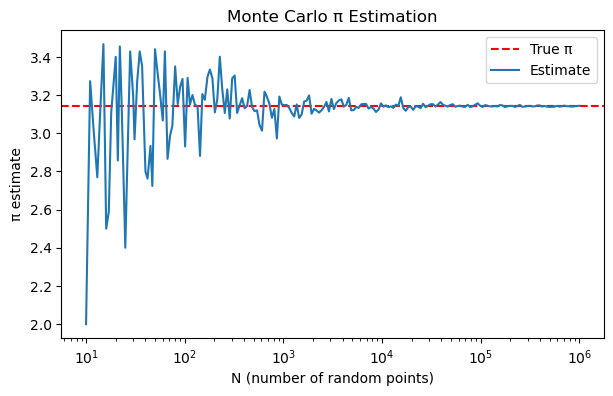

In [39]:

# Plot convergence of π estimation
Ns = np.unique(np.logspace(1, 6, num=200, dtype=int))  # 10 → 1,000,000
estimates = [estimate_pi(N) for N in Ns]

plt.figure(figsize=(7,4))
plt.axhline(math.pi, color="red", linestyle="--", label="True π")
plt.plot(Ns, estimates, label="Estimate", linewidth=1.5)
plt.xscale("log")
plt.xlabel("N (number of random points)")
plt.ylabel("π estimate")
plt.title("Monte Carlo π Estimation")
plt.legend()
plt.show()


Reflection 


As can be seen in the above graph, for small N, the estimate fluctuates widely due to randomness. As N grows, the estimates tend to π and the error decreases at rate ~ 1/√N, so doubling accuracy requires ~4× more samples. Overall, the Monte Carlo is a simple but succesful way of estimating π.


### 2. Chemistry inspired Monte Carlo  

**a. Simulate M random molecular collisions in a box.**

**b. Assign random energies to each collision (e.g., uniform or normal distribution).**

**c. Count how many collisions exceed a given threshold energy.**

**d. Interpret the fraction as an estimate of reaction probability.**

We now estimate the probability that a molecular collision exceeds an **energy threshold**.

Two energy distributions are considered:
- Uniform(0,10): equal chance of any energy between 0 and 10.
- Normal(mean=5, std=2): bell-shaped distribution around 5.

In [51]:

# Function to estimate reaction probability
def estimate_reaction_probability(M: int, threshold: float, distribution="uniform") -> float:
    if distribution == "uniform":
        # Energies uniformly distributed between 0 and 10
        energies = np.random.uniform(0, 10, M)
    elif distribution == "normal":
        # Energies normally distributed (mean=5, std=2)
        energies = np.random.normal(loc=5, scale=2, size=M)
    else:
        raise ValueError("Unknown distribution type")
    
    reactions = np.sum(energies >= threshold)  # count collisions above threshold
    return float(reactions / M)


_________________________________________________________________________________________________________________________________________________________
WRONG ATTEMPT: 
Using `>` instead of `>=`, since the reaction requires at least that energy for the reaction to happen the energy itself should be included. Addionally, at first we used a counter and a `for` loop to count them although this is not a mistake our final function used a cleaner and simpler method. 

In [52]:
def bad_count(M: int, threshold: float, distribution="uniform") -> float:
    if distribution == "uniform":
        energies = np.random.uniform(0, 10, M)
    elif distribution == "normal":
        energies = np.random.normal(loc=5, scale=2, size=M)
    else:
        raise ValueError("Unknown distribution type")
    
    count = 0
    for e in energies:
        if e > threshold:
            count += 1
    return count/M 

print("Uniform distribtuion, M=100000:", bad_count(100000, threshold=6, distribution="uniform"))

Uniform distribtuion, M=100000: 0.39883


_________________________________________________________________________________________________________________________________________________________

Example Estimates

To visualise this, we compute reaction probability for `M = 100,000` samples under both unifrom and normal distributions.

In [41]:

# Example: simulate with large M
print("Uniform distribtuion, M=100000:", estimate_reaction_probability(100000, threshold=6, distribution="uniform"))
print("Normal distribution,  M=100000:", estimate_reaction_probability(100000, threshold=6, distribution="normal"))


Uniform distribtuion, M=100000: 0.4016
Normal distribution,  M=100000: 0.3086


The results make sense since for a uniform distribution, every energy between 0 and 10 is equally likely.  
If the threshold is 6, then the fraction of values above 6 is just the length of the interval [6,10] which is 4 divided by the total interval [0,10]. So the probability is 4/10 = 0.4 (40%).  
The Monte Carlo estimate with M=100,000 is very close to 0.4.  
This means that in this model, about 40% of collisions have enough energy to cause a reaction.  

For the normal distribution, the probability is bell shaped around the midpoint meaning the energies will cluster around 5. So we are looking at the fraction of samples that are above 6.  
For a Normal(5,2), that probability is about 0.341.   
The Monte Carlo estimate with M=100,000 should be close to this true value.  
This means that in this model, around a third of collisions exceed the threshold, since most energies are clustered below 6.  

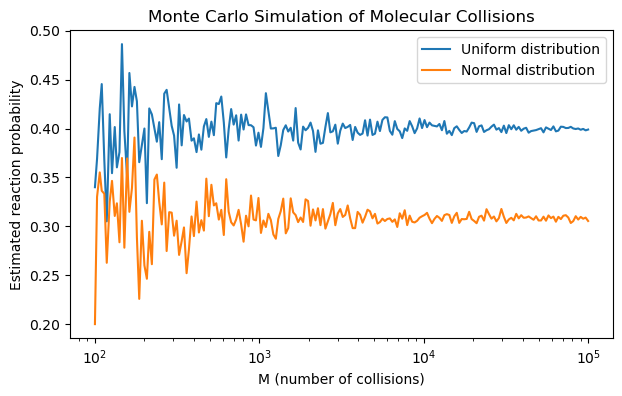

In [42]:

# Plot convergence of reaction probability
Ms = np.unique(np.logspace(2, 5, num=200, dtype=int))  # 100 → 100,000
estimates_uniform = [estimate_reaction_probability(M, threshold=6, distribution="uniform") for M in Ms]
estimates_normal  = [estimate_reaction_probability(M, threshold=6, distribution="normal") for M in Ms]

plt.figure(figsize=(7,4))
plt.plot(Ms, estimates_uniform, label="Uniform distribution", linewidth=1.5)
plt.plot(Ms, estimates_normal, label="Normal distribution", linewidth=1.5)
plt.xscale("log")
plt.xlabel("M (number of collisions)")
plt.ylabel("Estimated reaction probability")
plt.title("Monte Carlo Simulation of Molecular Collisions")
plt.legend()
plt.show()


Reflection

As can be seen, both distributions converge as M increases, but to different values. For Uniform(0,10) with threshold 6, the true probability is exactly 0.4. For the Normal(5,2) case, the probability is smaller (depends on the Gaussian tail). Monte Carlo reveals how distributional assumptions matter for predicting outcomes.

Overall, we found that Montecarlo provides an estimates for which the accuracy improves with more samples. This can be a useful method if the true probability is hard to calculate. In both analysis, we saw that as the number of samples increases, the estimated values cnverge to the theoretical value indicating succesful experiments. Thus, we see a clear trade-off between accuracy and computational cost.